In [3]:
import os
import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import PIL
from PIL import Image

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import transforms
from torch.optim import Adam
from torch.autograd import Variable

from tqdm import tqdm
import glob

In [4]:
train_path = 'F:/Mayur/DL/Dataset'
test_path = 'F:/Mayur/DL/Test-Dataset'

In [5]:
class_name = os.listdir(train_path)
print(class_name)

['2-wheeler', '4-wheeler', 'Bicycle', 'Buildings']


In [6]:
def get_count(each_class):
    return len(os.listdir(train_path + '/' + each_class))

In [10]:
for each_class in class_name:
    print("Number of samples in {} category {}".format(each_class, get_count(each_class)))

Number of samples in 2-wheeler category 2827
Number of samples in 4-wheeler category 2600
Number of samples in Bicycle category 2601
Number of samples in Buildings category 2628


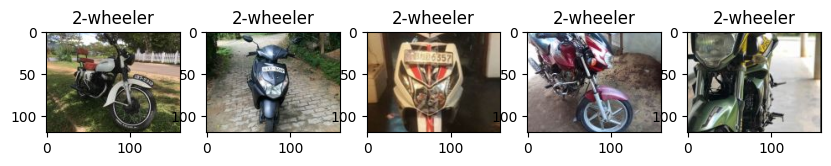

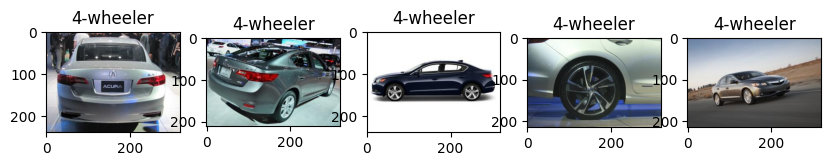

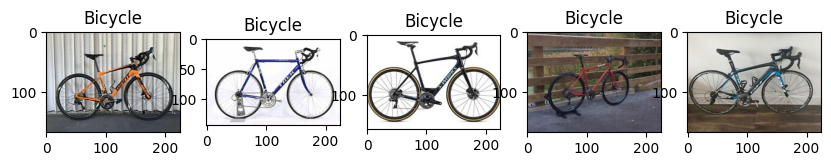

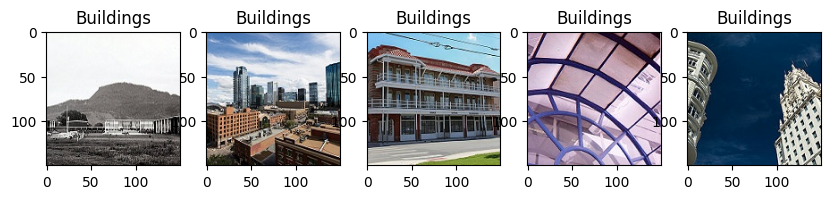

In [11]:
directory=os.listdir(train_path)
for each in directory:
    plt.figure(figsize=(10, 10))
    currentFolder = train_path + '/' + each
    for i, file in enumerate(os.listdir(currentFolder)[0:5]):
        fullpath = train_path + '/' + each + "/" + file
        img=mpimg.imread(fullpath)
        ax=plt.subplot(1,5,i+1)
        ax.set_title(each)
        plt.imshow(img)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
train_transformer = transforms.Compose([transforms.Resize((150,150)),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor()])
test_transformer = transforms.Compose([transforms.Resize((150,150)),
                                  transforms.ToTensor()])

In [11]:
train_loader  = DataLoader(torchvision.datasets.ImageFolder(train_path,transform=train_transformer),batch_size=10,shuffle=True)
test_loader  = DataLoader(torchvision.datasets.ImageFolder(test_path,transform=test_transformer),batch_size=10,shuffle=True)

In [7]:
class NeuralNet(nn.Module):
    def __init__(self,num_classes):
        super(NeuralNet,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.relu3 = nn.ReLU()
        
        self.fc = nn.Linear(in_features=32*75*75,out_features=num_classes)
        
    def forward(self,input):
        output = self.conv1(input)
        output = self.relu1(output)
        
        output = self.pool(output)
        
        output = self.conv2(output)
        output = self.relu2(output)
        
        output = self.conv3(output)
        output = self.relu3(output)
        
        output = output.view(-1,32*75*75)
        output = self.fc(output)
        
        return output

In [12]:
model = NeuralNet(num_classes=4).to(device)

In [13]:
optimizer = Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function = nn.CrossEntropyLoss()

In [14]:
num_epochs = 10

In [15]:
train_count = len(glob.glob(train_path+'/**/*.jpg'))
test_count = len(glob.glob(test_path+'/**/*.jpg'))

In [16]:
print(train_count,test_count)

10632 2000


In [332]:
best_accuracy = 0.0
for epoch in range(num_epochs):
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0
    
    for i ,(images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.cpu().data*images.size(0)
        _,prediction = torch.max(outputs.data,1)
        train_accuracy += int(torch.sum(prediction==labels.data))
    
    train_accuracy = train_accuracy/train_count
    train_loss = train_loss/train_count
    
    model.eval()
    
    test_accuracy = 0.0
    for i ,(images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
            
        outputs = model(images)
        _,prediction = torch.max(outputs.data,1)
        test_accuracy += int(torch.sum(prediction==labels.data))
    
    test_accuracy = test_accuracy/test_count
    
    print('Epoch: '+str(epoch)+'Train Loss : '+str(int(train_loss))+' Train Accuracy : '+str(train_accuracy)+' Test Accuracy : '+str(test_accuracy))
    
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy = test_accuracy

Epoch: 0Train Loss : 0 Train Accuracy : 0.8493227990970654 Test Accuracy : 0.8455
Epoch: 1Train Loss : 0 Train Accuracy : 0.9446012039127163 Test Accuracy : 0.962
Epoch: 2Train Loss : 0 Train Accuracy : 0.9683032355154252 Test Accuracy : 0.961
Epoch: 3Train Loss : 0 Train Accuracy : 0.9803423626787058 Test Accuracy : 0.9685
Epoch: 4Train Loss : 0 Train Accuracy : 0.9840105342362678 Test Accuracy : 0.971
Epoch: 5Train Loss : 0 Train Accuracy : 0.9894657637321295 Test Accuracy : 0.975
Epoch: 6Train Loss : 0 Train Accuracy : 0.9926636568848759 Test Accuracy : 0.964
Epoch: 7Train Loss : 0 Train Accuracy : 0.9946388261851016 Test Accuracy : 0.953
Epoch: 8Train Loss : 0 Train Accuracy : 0.9926636568848759 Test Accuracy : 0.968
Epoch: 9Train Loss : 0 Train Accuracy : 0.9928517682468021 Test Accuracy : 0.9725


In [17]:
net = NeuralNet(num_classes=4)
net.load_state_dict(torch.load('F:/Mayur/DL/best_checkpoint.model'))

<All keys matched successfully>

In [18]:
classess = ['2-wheeler', '4-wheeler', 'Bicycle', 'Buildings']
classess

['2-wheeler', '4-wheeler', 'Bicycle', 'Buildings']

[-2.6584964 -6.335771  -6.0941668 -5.240867 ]
Predicted Class:  2-wheeler


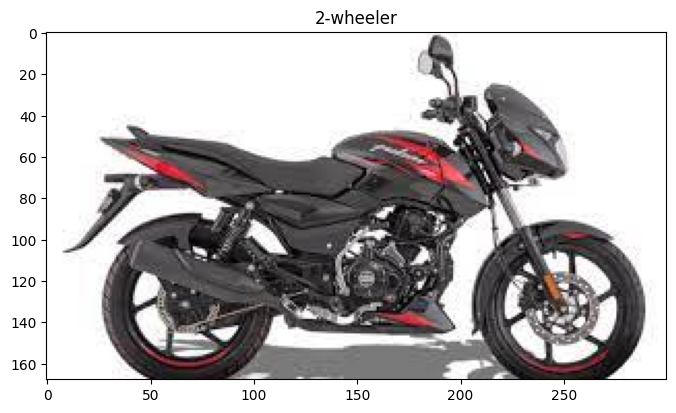

In [24]:
loader = transforms.Compose([transforms.Resize((150,150)),
                                  transforms.ToTensor()])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image 

imgpath = 'F:/Mayur/DL/t.jpg'
image = image_loader(imgpath)


prediction = net(image).detach().numpy()[0]
print(prediction)
index = np.where(prediction>=prediction.max())[0][0]
print("Predicted Class: ",classess[index])

plt.figure(figsize=(8, 8))
img=mpimg.imread(imgpath)
ax=plt.subplot(1,1,1)
ax.set_title(classess[index])
plt.imshow(img)